# Step 1: Data Download and organization
 Please see the Project Proposal in the repo for information on goals, data sources, and research questions. 

This notebook is the first step in Kealie Pretzlav's Springboard Capstone 2 project. 
This notebook downloads the appropriate datasets, merges them, and checks for missing values and duplicates. 
Further data processing will occur in future steps. 

In [1]:
import pandas as pd
import datetime as dt
import numpy as np

import geopandas as gpd
from shapely.geometry import Point
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

import os
from dotenv import load_dotenv
import requests

# import pynhd as nhd
# import xarray
from pynhd import NHD


## Flood Data
Flood occurence dataset from NOAA National Center for Environmental Information: https://www.ncdc.noaa.gov/stormevents/
Analysis uses storms which are labeled "Flood" or "Flash Flood". The database also includes other storm events such as tornados, hurricanes, and wind. 

Data is downloaded for 1996 to present; data is not available prior to 1996. 

In [2]:
### download storm data
storm_url = 'https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/'
file_list = list(pd.read_html(storm_url, skiprows=2)[0]['Parent Directory'].dropna())
years_to_dl = range(1996, 2022, 1) ##download data for 1996 on, no flood data prior
filename_to_dl = [f for f in file_list if 'details-ftp_v1.0_d' in f]

##initialize data subset rather than downloading whole storm event dataset
df_flood = pd.DataFrame()
flood_types = ['Flood', 'Flash Flood']

for year in years_to_dl:
    filename = [s for s in file_list if 'details-ftp_v1.0_d' + str(year) in s][0]
    df_flood_year = pd.read_csv(storm_url + filename, dtype='object')
    df_flood = pd.concat([df_flood, df_flood_year[df_flood_year['EVENT_TYPE'].isin(flood_types)]])
    # print(year)

df_flood.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
1,199610,21,900,199610,21,900,2052748,5570362,OKLAHOMA,40,...,NaN,NaN,DURANT,NaN,NaN,NaN,NaN,Flash flood waters washed out a small bridge a...,NaN,PDC
25,199601,24,1200,199601,24,1200,1000569,5536059,INDIANA,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"On the 23rd, many areas received around an inc...",NaN,PDC
34,199601,22,700,199601,31,1159,1002242,5549485,KENTUCKY,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Snowmelt and heavy rain caused widespread floo...,NaN,PDC
44,199601,26,2330,199601,27,630,2404288,5537263,NORTH CAROLINA,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Prolonged rain became heavier following the ic...,NaN,PDC
69,199601,19,830,199601,20,700,2057213,5583210,NEW YORK,36,...,NaN,NaN,COUNTYWIDE,NaN,NaN,NaN,NaN,NaN,NaN,PDC


In [3]:
#view the data
df_flood.head().T

,1,25,34,44,69
BEGIN_YEARMONTH,199610,199601,199601,199601,199601
BEGIN_DAY,21,24,22,26,19
BEGIN_TIME,900,1200,700,2330,830
END_YEARMONTH,199610,199601,199601,199601,199601
END_DAY,21,24,31,27,20
END_TIME,900,1200,1159,630,700
EPISODE_ID,2052748,1000569,1002242,2404288,2057213
EVENT_ID,5570362,5536059,5549485,5537263,5583210
STATE,OKLAHOMA,INDIANA,KENTUCKY,NORTH CAROLINA,NEW YORK
STATE_FIPS,40,18,21,37,36


In [4]:
## take a look at flood causes
df_flood.describe().T
df_flood['FLOOD_CAUSE'].value_counts()

FLOOD_CAUSE
Heavy Rain                      88730
Heavy Rain / Snow Melt           4917
Heavy Rain / Tropical System     2431
Heavy Rain / Burn Area            738
Ice Jam                           698
Dam / Levee Break                 231
Planned Dam Release               175
Name: count, dtype: int64

In [5]:
##change col names to lowercase
df_flood.columns = df_flood.columns.str.lower()
df_flood.columns


Index(['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
       'end_day', 'end_time', 'episode_id', 'event_id', 'state', 'state_fips',
       'year', 'month_name', 'event_type', 'cz_type', 'cz_fips', 'cz_name',
       'wfo', 'begin_date_time', 'cz_timezone', 'end_date_time',
       'injuries_direct', 'injuries_indirect', 'deaths_direct',
       'deaths_indirect', 'damage_property', 'damage_crops', 'source',
       'magnitude', 'magnitude_type', 'flood_cause', 'category', 'tor_f_scale',
       'tor_length', 'tor_width', 'tor_other_wfo', 'tor_other_cz_state',
       'tor_other_cz_fips', 'tor_other_cz_name', 'begin_range',
       'begin_azimuth', 'begin_location', 'end_range', 'end_azimuth',
       'end_location', 'begin_lat', 'begin_lon', 'end_lat', 'end_lon',
       'episode_narrative', 'event_narrative', 'data_source'],
      dtype='object')

In [6]:
print(df_flood.shape)


(153990, 51)


/var/folders/k2/8b5d5rd53t38_t4lfc676zsr0000gp/T/ipykernel_14206/2766726960.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_flood[flood_numeric_names] = df_flood[flood_numeric_names].apply(pd.to_numeric, errors='ignore')


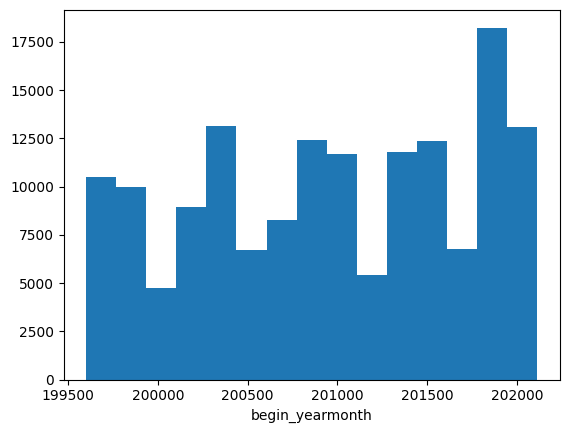

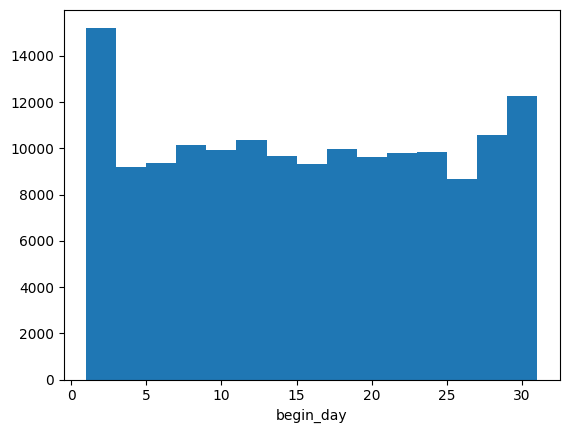

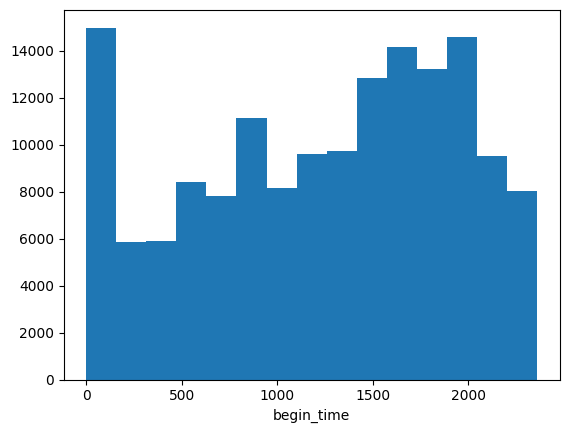

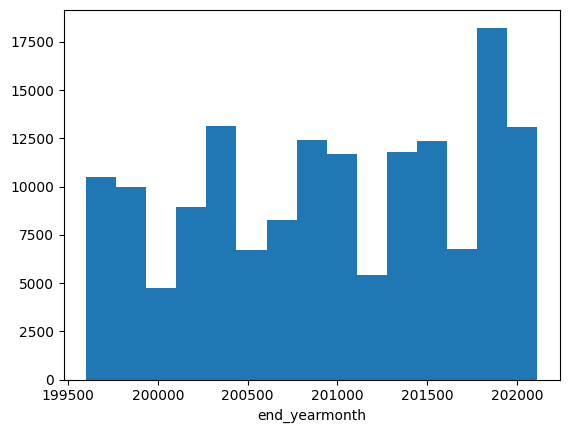

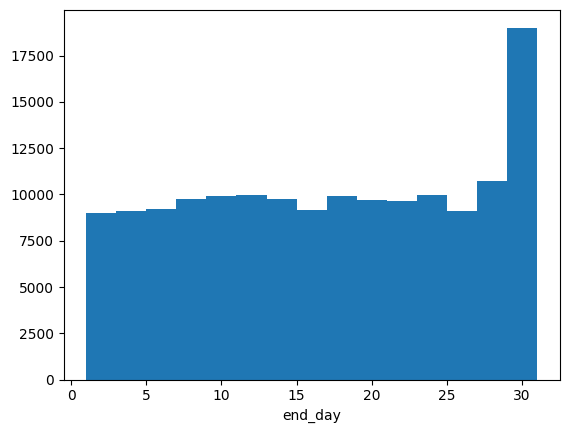

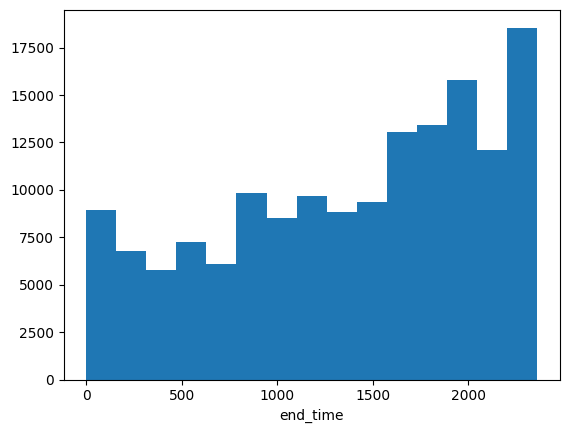

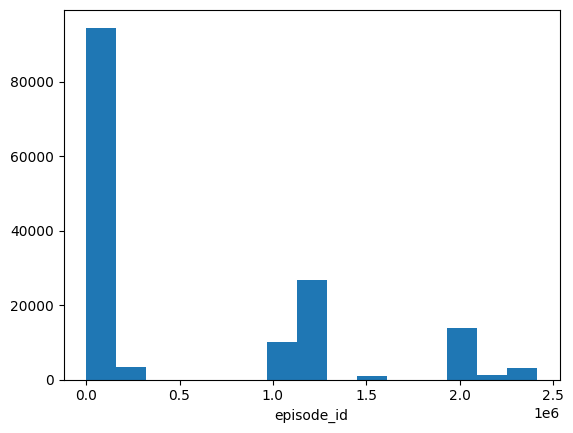

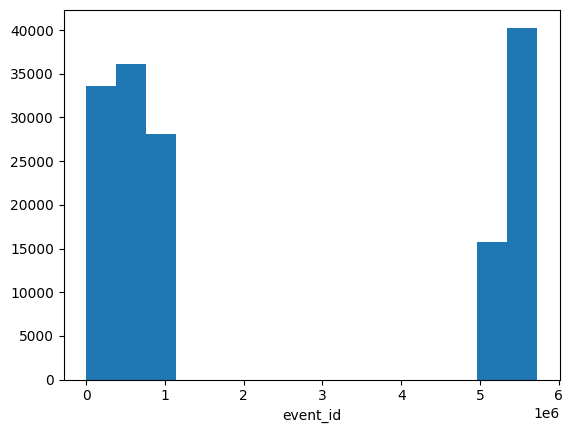

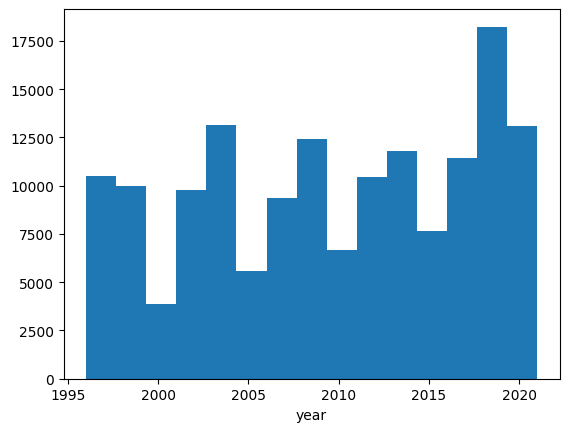

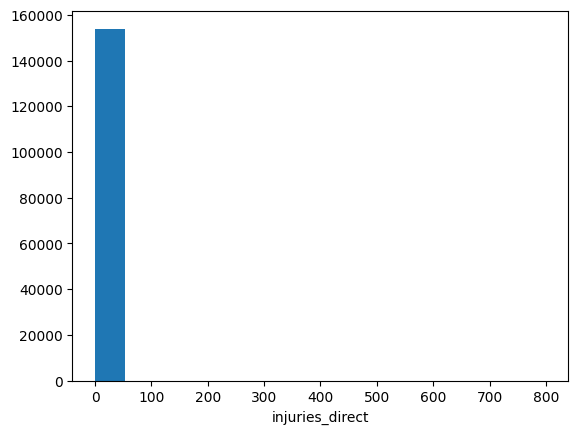

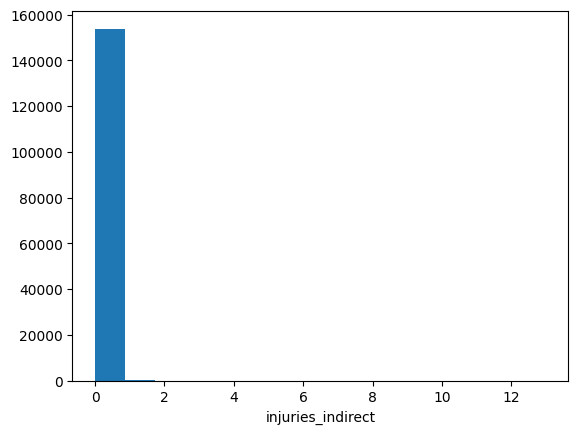

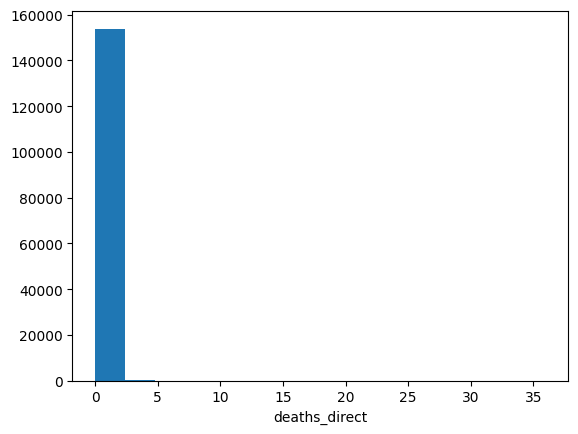

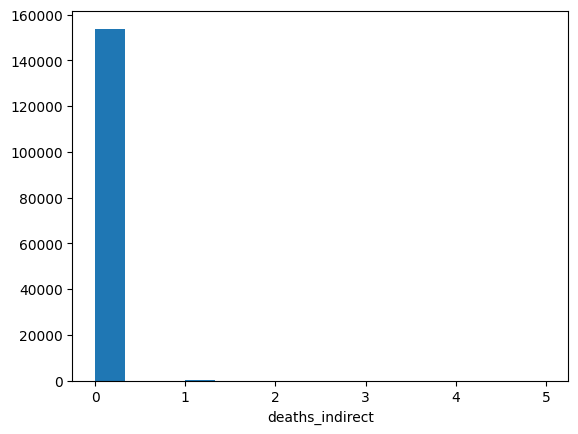

In [7]:
##check for outliers
flood_numeric_names = ['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
                       'end_day', 'end_time', 'episode_id', 'event_id','year',
                       'injuries_direct', 'injuries_indirect', 'deaths_direct','deaths_indirect']
df_flood[flood_numeric_names] = df_flood[flood_numeric_names].apply(pd.to_numeric, errors='ignore')
### check numeric outliers
for n in df_flood[flood_numeric_names].columns:
    plt.hist(df_flood[flood_numeric_names][n], bins=15)
    plt.xlabel(n)
    plt.show()



_Things to notice about histograms/outliers_
- Time start and day start suggests a slight bias toward the start/end day and first/end time, suggesting unknown data uses these as defaults
- outlier on injuries_direct, injuries_indirect, deaths_direct, deaths_indirect. Unsure if that is real or unknown data. Appears as though many events just have missing injuries/death data. 


In [8]:
##check for missing values in key columns
df_flood.isna().sum()

begin_yearmonth            0
begin_day                  0
begin_time                 0
end_yearmonth              0
end_day                    0
end_time                   0
episode_id                 0
event_id                   0
state                      0
state_fips                 0
year                       0
month_name                 0
event_type                 0
cz_type                    0
cz_fips                    0
cz_name                    0
wfo                        0
begin_date_time            0
cz_timezone                0
end_date_time              0
injuries_direct            0
injuries_indirect          0
deaths_direct              0
deaths_indirect            0
damage_property        35527
damage_crops           49988
source                 13380
magnitude             153892
magnitude_type        153989
flood_cause            56070
category              153990
tor_f_scale           153990
tor_length            153990
tor_width             153990
tor_other_wfo 

Lots of columns have mostly missing data. Drop columns with more than 100k missing values (tor_ columns are for tornado events). Also drop columns that aren't needed. 

In [9]:
### done need all the data, drop some now to clean up
df_flood = df_flood.dropna(thresh=100000, axis=1)
df_flood_drop = df_flood.drop(['begin_range', 'begin_azimuth', 'begin_location', 'end_range', 'end_azimuth', 'end_location'], axis=1)
##
df_flood_drop.columns

Index(['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
       'end_day', 'end_time', 'episode_id', 'event_id', 'state', 'state_fips',
       'year', 'month_name', 'event_type', 'cz_type', 'cz_fips', 'cz_name',
       'wfo', 'begin_date_time', 'cz_timezone', 'end_date_time',
       'injuries_direct', 'injuries_indirect', 'deaths_direct',
       'deaths_indirect', 'damage_property', 'damage_crops', 'source',
       'begin_lat', 'begin_lon', 'end_lat', 'end_lon', 'episode_narrative',
       'event_narrative', 'data_source'],
      dtype='object')

Lat/Long has lots of missing values. How many have both begin and end lat or long missing? 

In [10]:
print('lat counts: ', df_flood_drop[['begin_lat', 'end_lat']].isna().sum(1).value_counts())
print('lon counts: ', df_flood_drop[['begin_lon', 'end_lon']].isna().sum(1).value_counts())
print('all lat/long counts: ', df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat']].isna().sum(1).value_counts())

lat counts:  0    103535
2     50455
Name: count, dtype: int64
lon counts:  0    103535
2     50455
Name: count, dtype: int64
all lat/long counts:  0    103535
4     50455
Name: count, dtype: int64


50k are missing all lat/long info. Isolated to older data? Specific state?

<Axes: >

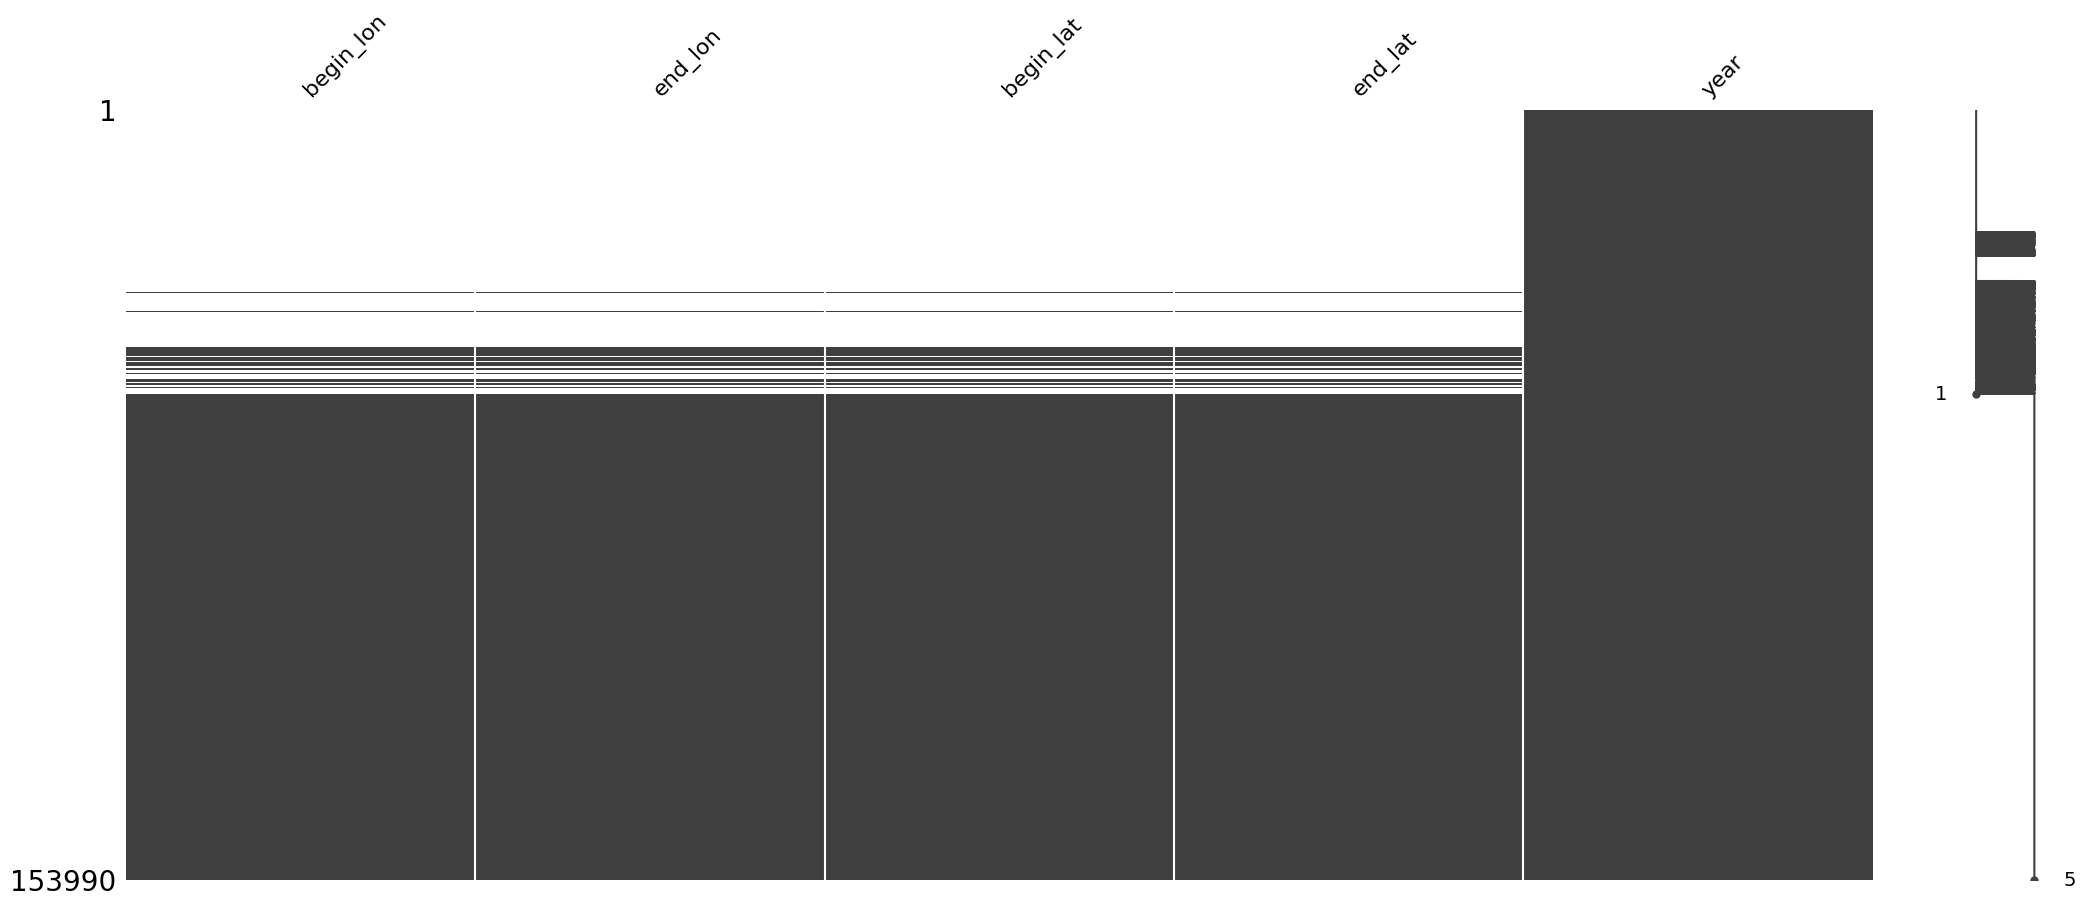

In [11]:
msno.matrix(df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat', 'year']].sort_values('year'))

<Axes: >

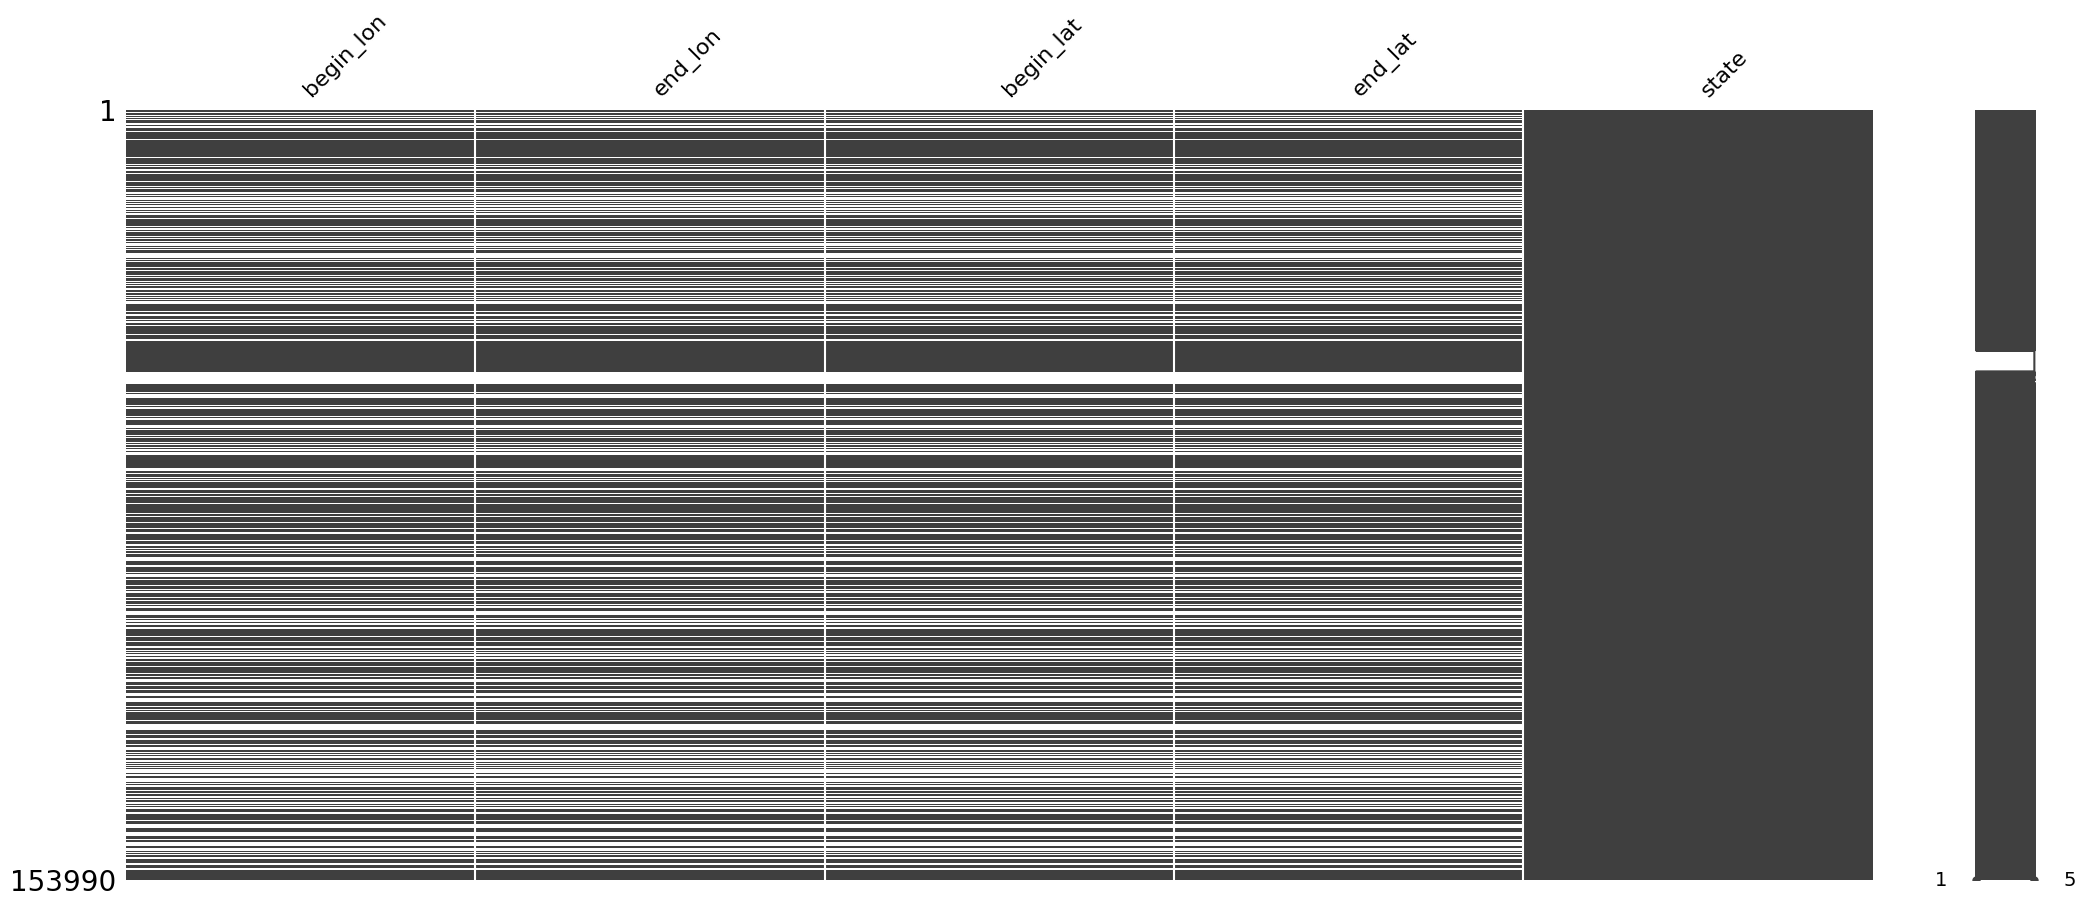

In [12]:
msno.matrix(df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat', 'state']].sort_values('state'))

Missing lat/long for older data, not isolated to specific geographic locations. What percentage of each year is missing? 

In [13]:
df_missingloc = df_flood_drop.loc[df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat']].isna().sum(1) == 4, :]
df_missingloc['year'].value_counts().sort_index()  / df_flood_drop.groupby('year').count()['event_id'] * 100

year
1996    100.000000
1997    100.000000
1998    100.000000
1999    100.000000
2000    100.000000
2001     96.596367
2002    100.000000
2003     95.012107
2004     96.599914
2005     24.605452
2006     63.469493
2007           NaN
2008           NaN
2009           NaN
2010           NaN
2011           NaN
2012           NaN
2013           NaN
2014           NaN
2015           NaN
2016           NaN
2017           NaN
2018           NaN
2019           NaN
2020           NaN
2021           NaN
dtype: float64

Looks like most missing data is in early years. We'll drop missing for now, but note the percentage of missing lat/long for 2001 - 2006 may make those years less helpful. Nan in 2007 on becuase no missing values. 

In [14]:

df_flood_drop2 = df_flood_drop.dropna(subset=['begin_lon', 'end_lon', 'begin_lat', 'end_lat'])
print('number floods before dropping missing locs:', len(df_flood_drop), 'number floods after dropping:', len(df_flood_drop2))

number floods before dropping missing locs: 153990 number floods after dropping: 103535


## Download shapefiles of each Census Tract

In [15]:
#import 2020 census zip code tabulation areas
file_list = pd.read_html('https://www2.census.gov/geo/tiger/TIGER2020/TRACT/')[0].loc[2:57, 'Name']
tracts = pd.DataFrame()
for filename in file_list:
    this_tract = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2020/TRACT/' + filename)
    # this_tract.index = this_tract['TRACTCE']
    tracts = pd.concat([tracts, this_tract])
    # print(tracts.shape)
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,01,045,020801,01045020801,208.01,Census Tract 208.01,G5020,S,19261326,0,+31.3971437,-085.6615959,"POLYGON ((-85.70064 31.38509, -85.70043 31.385..."
1,01,017,954200,01017954200,9542,Census Tract 9542,G5020,S,62998696,34641,+32.8341436,-085.2678516,"POLYGON ((-85.31549 32.80580, -85.31354 32.808..."
2,01,017,953800,01017953800,9538,Census Tract 9538,G5020,S,515692207,11516898,+33.0302580,-085.3867880,"POLYGON ((-85.59345 33.00012, -85.59333 33.000..."
3,01,017,954300,01017954300,9543,Census Tract 9543,G5020,S,132642536,178276,+32.7766468,-085.2734917,"POLYGON ((-85.38077 32.78301, -85.37985 32.782..."
4,01,017,954700,01017954700,9547,Census Tract 9547,G5020,S,38036820,264376,+32.7702191,-085.1744682,"POLYGON ((-85.22897 32.74543, -85.22894 32.745..."


In [16]:
# Census TIGER files use NAD83
tracts.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

Create point geometry for each flood event, join with tract polygon. 

## merge tract data to flood dataset


In [17]:
## create point geometry, use flood begin coordinates (puts event closer to flood source)
df_loc = pd.DataFrame([Point(str(x),str(y)) for x, y in zip(df_flood_drop2['begin_lon'], df_flood_drop2['begin_lat'])], columns=['locstr'])
df_loc.index = df_flood_drop2['event_id']

# convert to geodataframe with coordinate system WGS84, ie Lat/long
gdf_flood = gpd.GeoDataFrame(df_loc, geometry='locstr', crs='EPSG:4326')
gdf_flood.to_crs('EPSG:4269', inplace=True) #reproject to NAD83
gdf_tract = gpd.sjoin(gdf_flood, tracts, how='left')
print(gdf_tract.shape)
gdf_tract.head()

(103536, 14)


,locstr,index_right,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
event_id,,,,,,,,,,,,,,
5276096,POINT (-88.83333 35.61667),876.0,47,113,000700,47113000700,7,Census Tract 7,G5020,S,2352646.0,0.0,+35.6215283,-088.8292753
5240447,POINT (-89.25000 32.75000),751.0,28,099,940100,28099940100,9401,Census Tract 9401,G5020,S,105020176.0,147638.0,+32.7880705,-089.2456666
5238548,POINT (-89.83333 31.41667),571.0,28,065,950202,28065950202,9502.02,Census Tract 9502.02,G5020,S,404792374.0,1238500.0,+31.4930936,-089.8814858
5238549,POINT (-89.75000 31.45000),572.0,28,065,950201,28065950201,9502.01,Census Tract 9502.01,G5020,S,241149697.0,410513.0,+31.5011243,-089.6792443
5238551,POINT (-89.55000 31.41667),665.0,28,073,020101,28073020101,201.01,Census Tract 201.01,G5020,S,87157380.0,150524.0,+31.4080651,-089.5973222


# Download Census Data

In [18]:
##load census API Key

load_dotenv()
API_KEY = os.getenv('census_api_key')


In [19]:
##merge zip code back to flood data, remove events with missing zip code
# inner merge to keep only floods, don't need all tract geometry for this step (geometry only needed to map floods to census data)
df_flood_tract = df_flood_drop2.merge(gdf_tract[['TRACTCE', 'STATEFP', 'COUNTYFP']], how='inner', left_on='event_id', right_index=True)
df_flood_tract = df_flood_tract.dropna(subset='TRACTCE')
print(df_flood_tract.shape)
df_flood_tract.head()

(103468, 37)


,begin_yearmonth,begin_day,begin_time,end_yearmonth,end_day,end_time,episode_id,event_id,state,state_fips,...,begin_lat,begin_lon,end_lat,end_lon,episode_narrative,event_narrative,data_source,TRACTCE,STATEFP,COUNTYFP
1426,200111,26,2100,200111,26,2300,1125447,5276096,TENNESSEE,47,...,35.61667,-88.83333,35.61667,-88.83333,NaN,Several buildings had water in their basements...,PDS,000700,47,113
7965,200104,4,1800,200104,4,2300,1113012,5240447,MISSISSIPPI,28,...,32.75,-89.25,32.75,-89.25,NaN,A significant flash flood event occurred due t...,PDS,940100,28,099
8121,200103,2,1530,200103,2,1730,1112592,5238548,MISSISSIPPI,28,...,31.41667,-89.83333,31.41667,-89.83333,NaN,Localized flooding of roads occurred in wester...,PDS,950202,28,065
8122,200103,2,1530,200103,2,1800,1112592,5238549,MISSISSIPPI,28,...,31.45,-89.75,31.45,-89.75,NaN,Localized flooding occurred on the streets in ...,PDS,950201,28,065
8124,200103,3,400,200103,3,600,1112592,5238551,MISSISSIPPI,28,...,31.41667,-89.55,31.38333,-89.55,NaN,A few roads in the county had flooding.,PDS,020101,28,073


In [20]:
##define census data variables to pull, and the data label
# variables: https://api.census.gov/data/2022/acs/acs5/variables.html

fields_dict = {'NAME': 'Name',
               # 'B19081_001E': 'houseinc_1',
               # 'B19081_002E': 'houseinc_2',
               # 'B19081_003E': 'houseinc_3',
               # 'B19081_004E': 'houseinc_4',
               # 'B19081_005E': 'houseinc_5',
               # 'B19081_006E': 'houseinc_top5',
               'B19013_001E': 'med_houseinc_12mon',
               'B19058_001E': 'household_public_assistance1', 
               'B19083_001E': 'gini',
               'B19081_001E': 'total_population',
               'B01001_002E': 'total_male', 
               'B01001_026E': 'total_female', 
               'B08303_001E': 'total_travel_time_to_work', 
               'B25105_001E': 'median_monthly_housing_costs', 
               
               'B25104_001E': 'total_monthlyHousingCosts', 
               'B25104_002E': 'total_HousingCosts_lessThan100', 
               # 'B25104_003E': 'total_HousingCosts_100To199', 
               # 'B25104_004E': 'total_HousingCosts_200To299', 
               # 'B25104_005E': 'total_HousingCosts_300TO399', 
               # 'B25104_006E': 'total_HousingCosts_400To499', 
               'B25104_007E': 'total_HousingCosts_500To599', 
               # 'B25104_008E': 'total_HousingCosts_600To699', 
               # 'B25104_009E': 'total_HousingCosts_700To799', 
               # 'B25104_010E': 'total_HousingCosts_800To899', 
               # 'B25104_011E': 'total_HousingCosts_900To999', 
               'B25104_012E': 'total_HousingCosts_1000To1499', 
               'B25104_013E': 'total_HousingCosts_1500To1999', 
               'B25104_014E': 'total_HousingCosts_2000To2499', 
               'B25104_015E': 'total_HousingCosts_2500To2999', 
               'B25104_016E': 'total_HousingCosts_3000OrMore', 
               # 'B25104_017E': 'total_HousingCosts_noCashRent', 
               
               'B01002_002E': 'median_age_male', 
               'B01002_003E': 'median_age_female', 
               
               # 'B15002_003E': 'education_noSchoolCompleted_maleOver25', 
               # 'B15002_020E': 'education_noSchoolCompleted_femaleOver25', 

               'B15003_017E': 'education_regularHSDiploma_over25',
               'B15003_018E': 'education_GEDAlt_over25',
               'B15003_019E': 'education_someCollegeLessThan1Yr_over25',
               'B15003_020E': 'education_someCollegeMoreThan1YrNoDegree_over25',
               'B15003_021E': 'education_associatesDegree_over25',
               'B15003_022E': 'education_BachelorsDegree_over25',
               'B15003_023E': 'education_mastersDegree_over25', 
               'B15003_024E': 'education_professionalSchoolDegree_over25', 
               'B15003_025E': 'education_doctorateDegree_over25', 

               'B18101_001E': 'male_35-64_withdisability',
               'B18101_032E': 'female_35-64_withdisability',
               'C16002_002E': 'householdLanguage_englishOnly', 
               'C16002_004E': 'householdLanguage_SpanishLimitedEnglish',
               'C16002_005E': 'householdLanguage_SpanishNotLimitedEnglish', 
               
               'C24050_002E': 'industry_agForestryEtc', 
               'C24050_003E': 'industry_construction', 
               'C24050_004E': 'industry_manufacturing', 
               'C24050_005E': 'industry_wholesaleTrade', 
               'C24050_006E': 'industry_retailTrade', 
               'C24050_007E': 'industry_transportationWarehousingUtilities', 
               'C24050_008E': 'industry_information', 
               'C24050_009E': 'industry_financeInsuranceRealEstate', 
               'C24050_010E': 'industry_professionalScientificManagementEtc', 
               'C24050_011E': 'industry_educationHealcareSocialAssistance', 
               'C24050_012E': 'industry_artsEntertainmentRecreationAccommodation',
               'C24050_013E': 'industry_otherServices', 
               'C24050_014E': 'industry_publicAdmin', 
               'C24050_015E': 'industry_managementBusinessScienceArts' 
              }

fields = ','.join(list(fields_dict.keys()))
names = list(fields_dict.values()) + ['state', 'county', 'tract']


In [21]:
### request data from api, put into dataframe

# loop through each state (Census tract data only downloaded by state)

#only lower 48
states_to_drop = ['GUAM', 'VIRGIN ISLANDS', 'DISTRICT OF COLUMBIA', 'HAWAII', 'ALASKA', 'AMERICAN SAMOA', 'PUERTO RICO']

#drop territories and alaska and hawaii, pull out unique fips code
state_fips_list = df_flood_tract.loc[~df_flood_tract['state'].isin(states_to_drop), 'state_fips'].unique()

df_census = pd.DataFrame()

for state in state_fips_list:
    url = 'https://api.census.gov/data/2022/acs/acs5?get=' + fields + '&for=tract:*&in=state:' + str(state.zfill(2)) + ' county:*&key=' + API_KEY

    r_test = requests.get(url)
    r_test.json()
    this_df_census = pd.DataFrame(r_test.json()[1::], columns=names)
    df_census = pd.concat([df_census, this_df_census], ignore_index=True, axis=0)

print(df_census.shape)
df_census.head()

(83571, 50)


,Name,med_houseinc_12mon,household_public_assistance1,gini,total_population,total_male,total_female,total_travel_time_to_work,median_monthly_housing_costs,total_monthlyHousingCosts,...,industry_financeInsuranceRealEstate,industry_professionalScientificManagementEtc,industry_educationHealcareSocialAssistance,industry_artsEntertainmentRecreationAccommodation,industry_otherServices,industry_publicAdmin,industry_managementBusinessScienceArts,state,county,tract
0,Census Tract 201; Anderson County; Tennessee,40739,1531,0.3936,10473,1453,1726,1206,872,1531,...,65,239,328,85,52,42,414,47,001,020100
1,Census Tract 202.01; Anderson County; Tennessee,103906,2029,0.4327,25267,2162,2558,1901,1191,2029,...,71,561,432,153,152,147,1264,47,001,020201
2,Census Tract 202.02; Anderson County; Tennessee,68536,1951,0.4561,7861,2410,2112,1553,1094,1951,...,49,257,233,18,84,64,592,47,001,020202
3,Census Tract 203; Anderson County; Tennessee,67610,1567,0.3719,18841,2012,2230,1589,1022,1567,...,72,291,311,142,93,41,589,47,001,020300
4,Census Tract 204; Anderson County; Tennessee,62941,1812,0.3840,16559,2240,2192,1727,933,1812,...,37,370,594,133,42,24,836,47,001,020400


/var/folders/k2/8b5d5rd53t38_t4lfc676zsr0000gp/T/ipykernel_14206/1165663743.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_census[census_numeric_names] = df_census[census_numeric_names].apply(pd.to_numeric, errors='ignore')


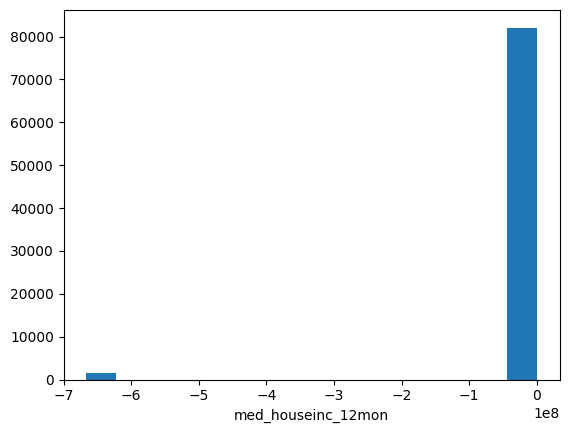

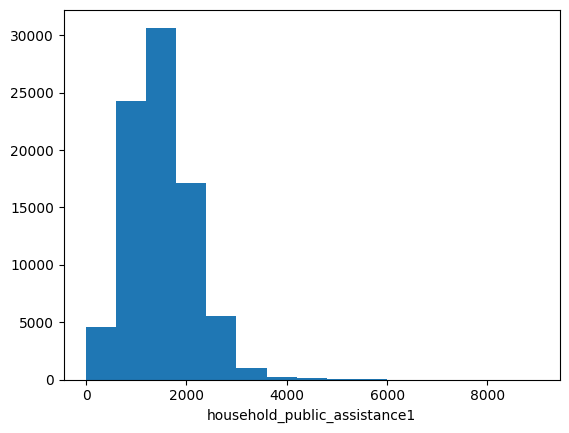

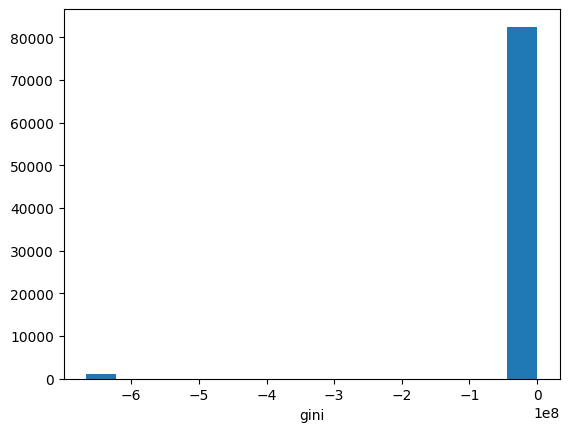

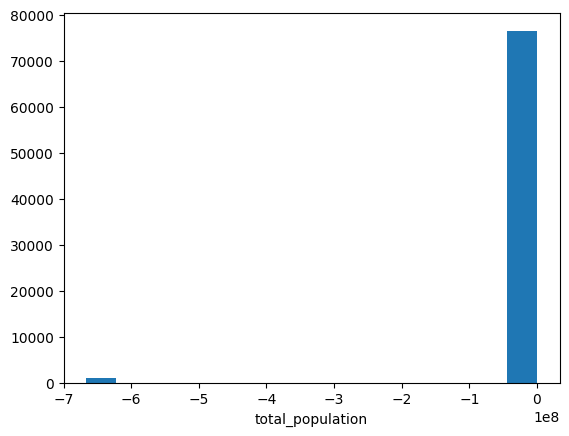

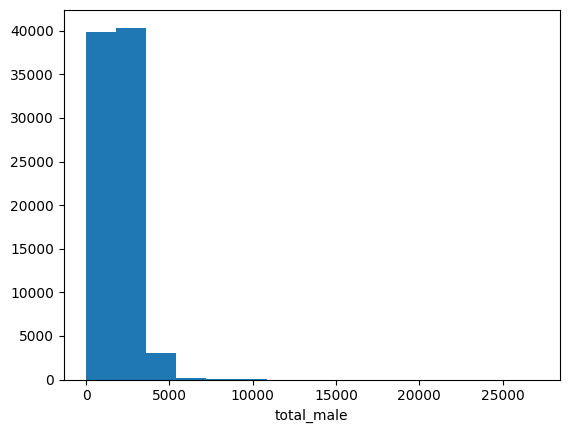

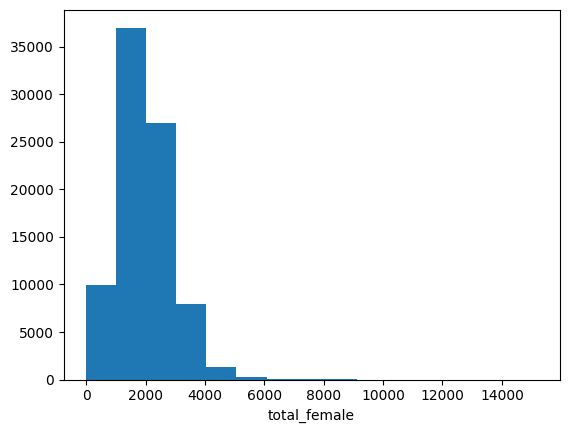

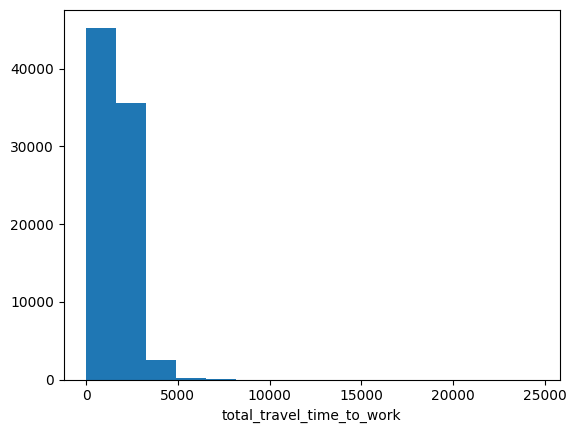

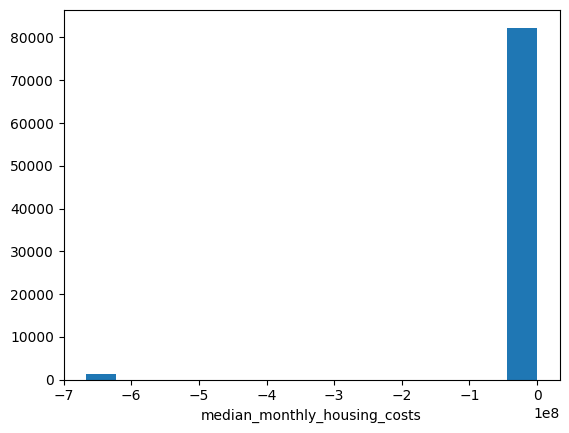

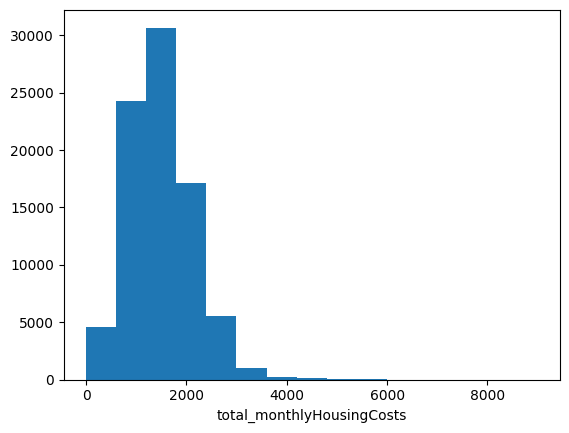

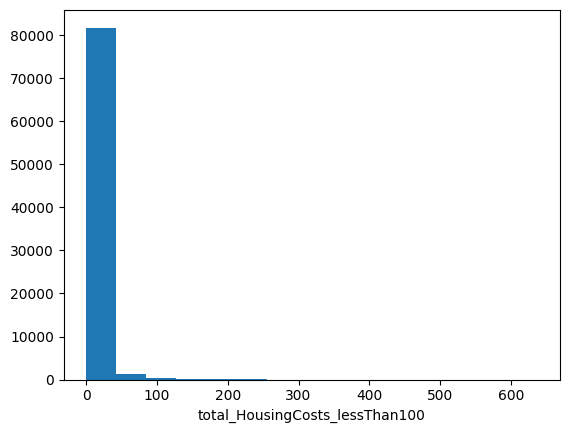

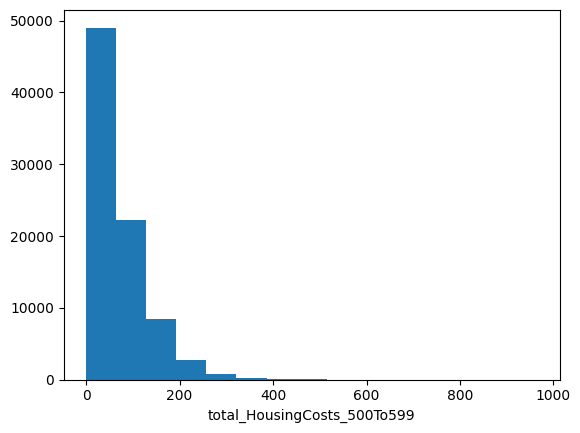

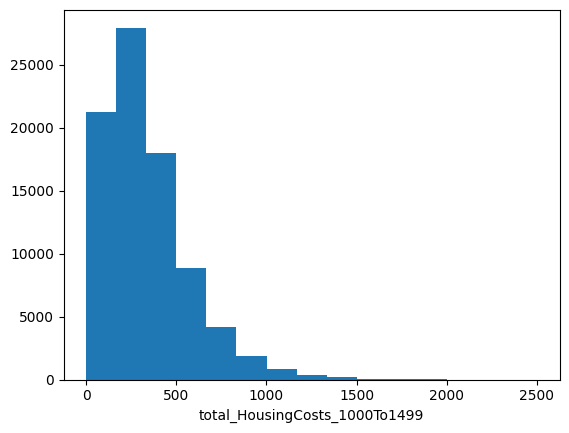

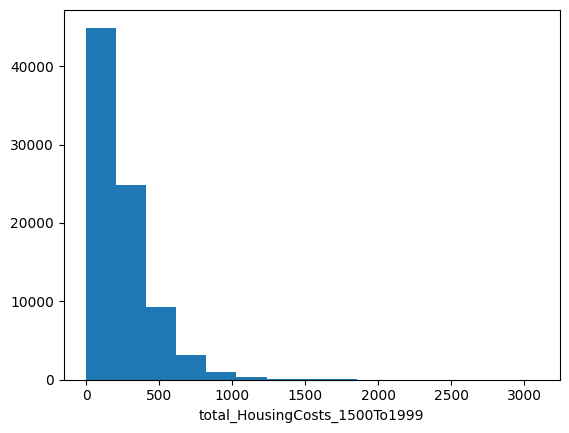

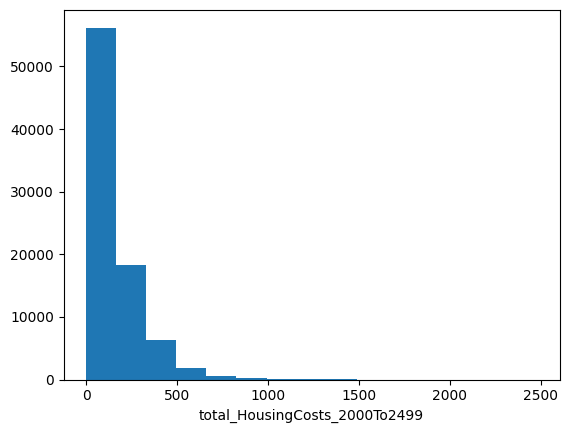

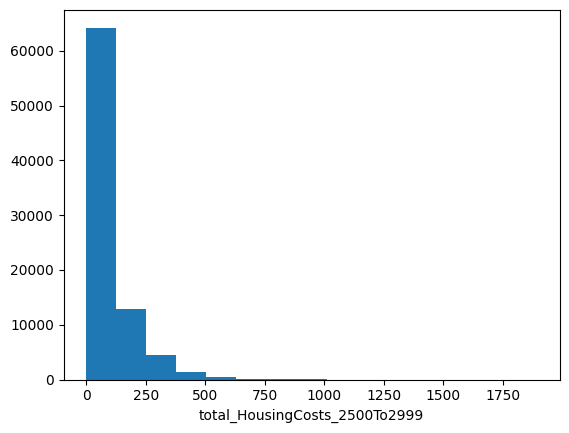

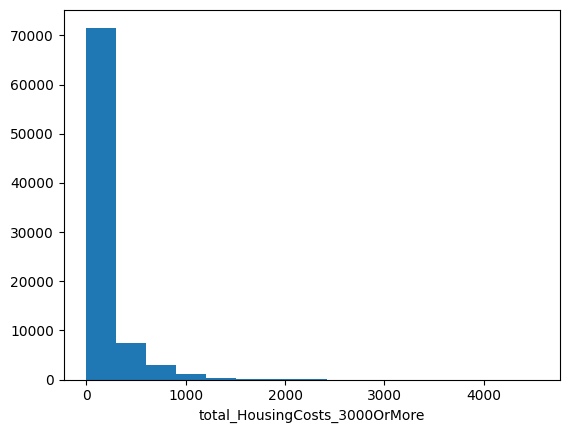

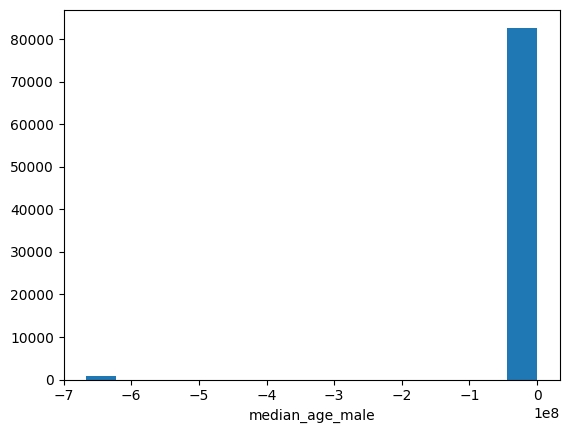

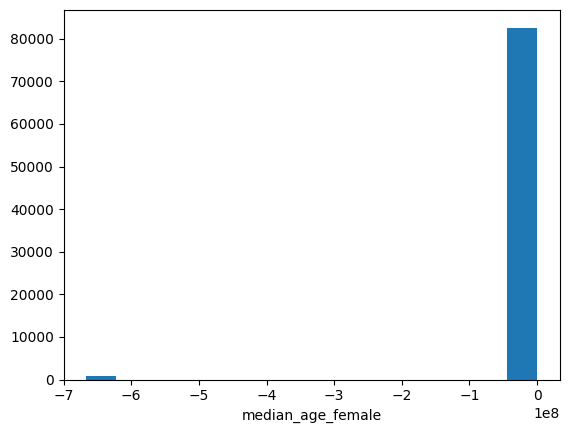

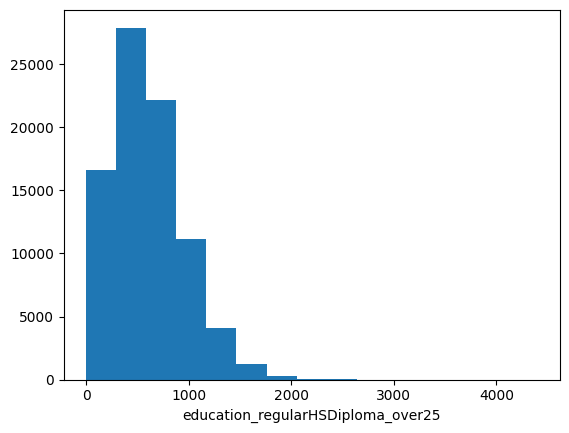

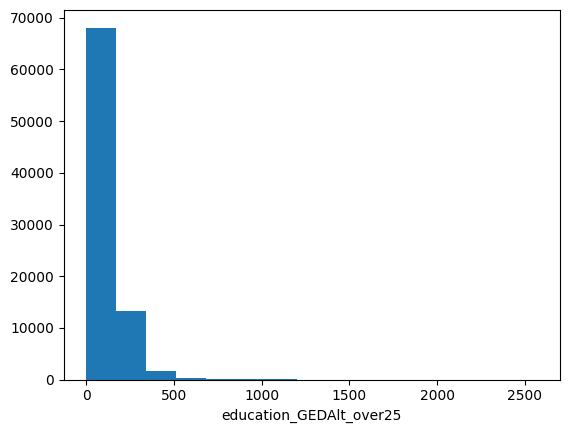

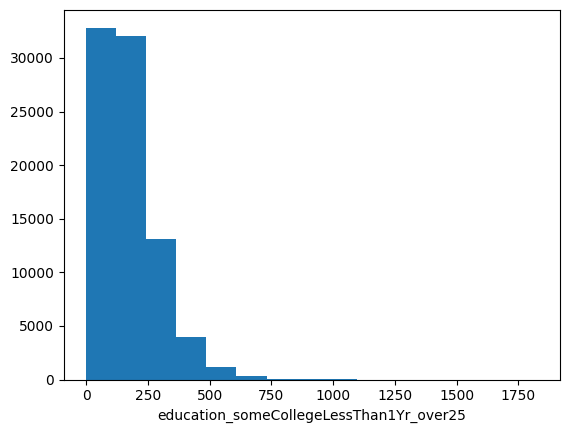

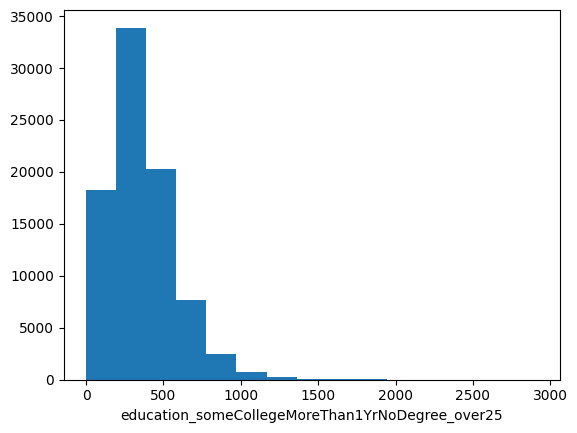

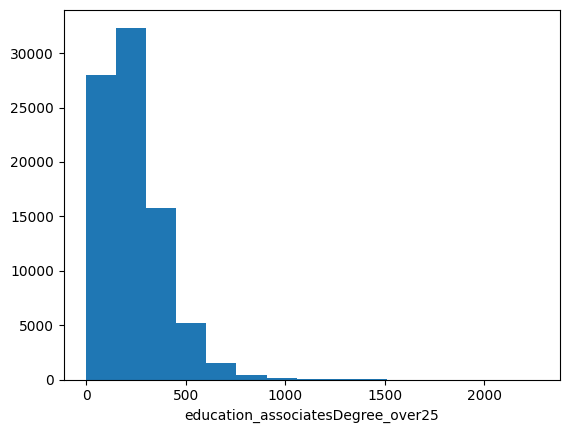

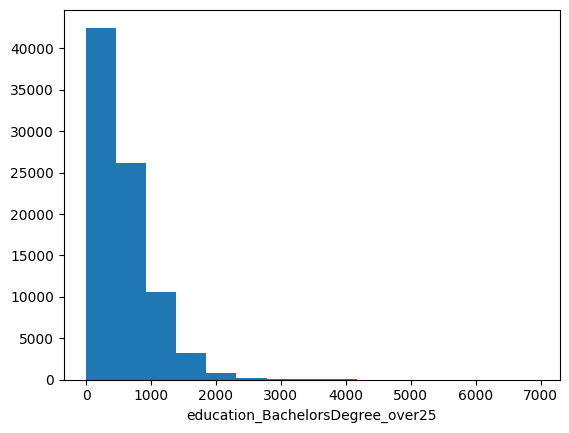

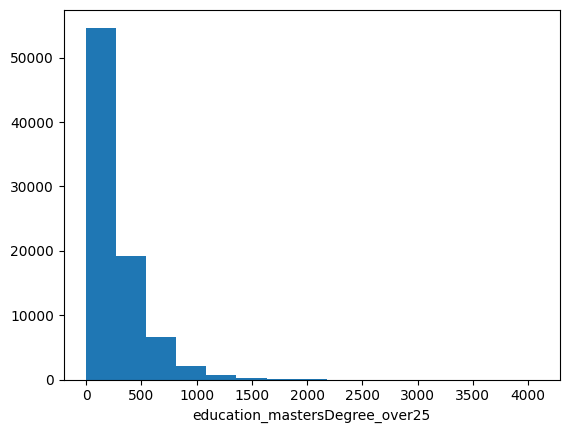

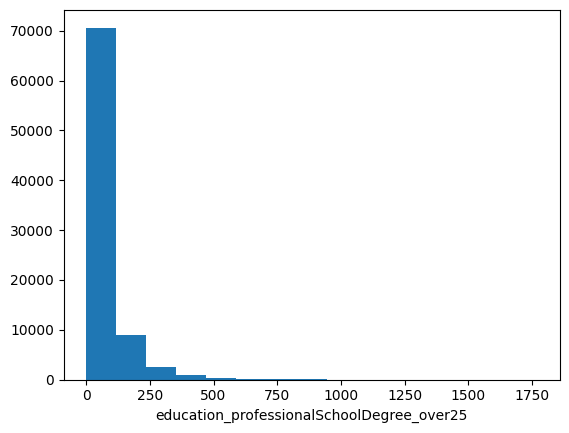

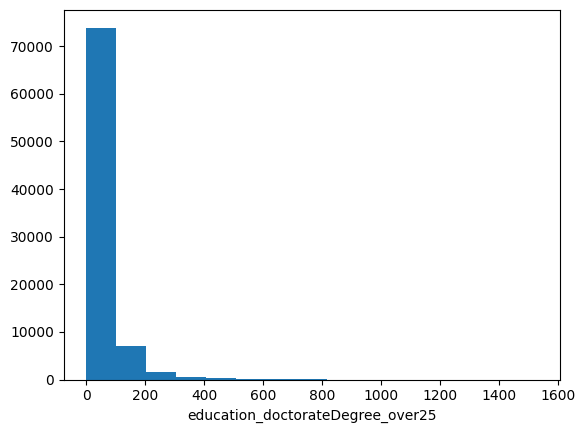

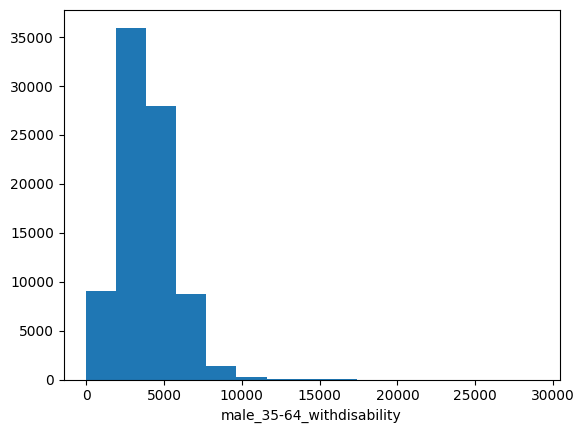

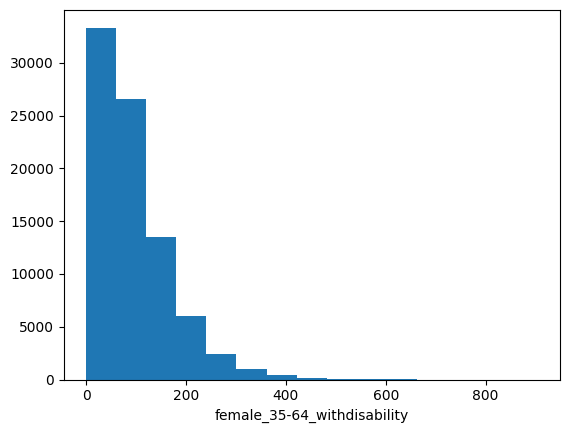

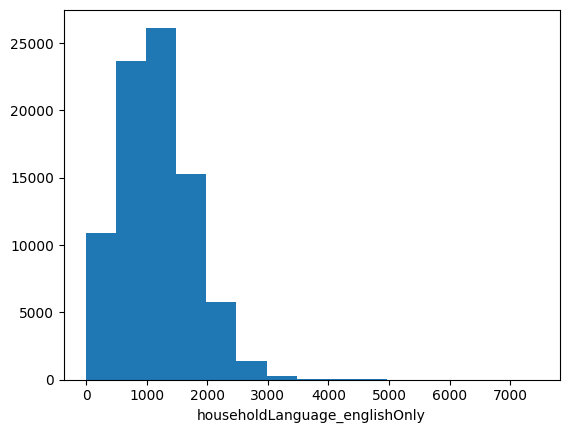

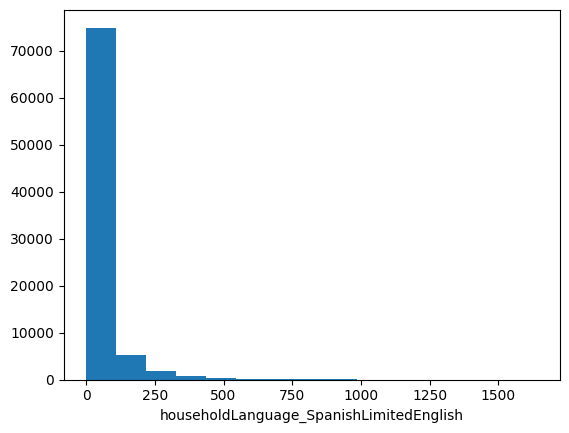

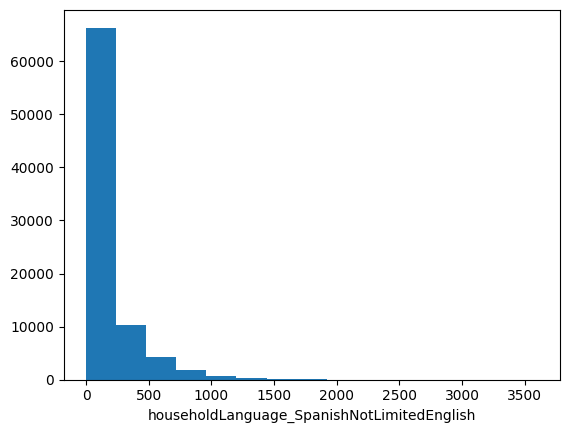

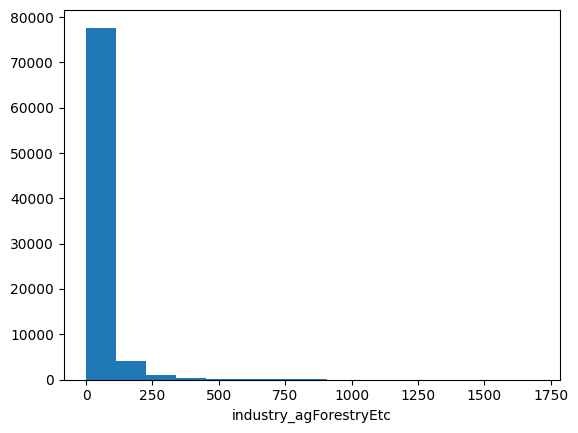

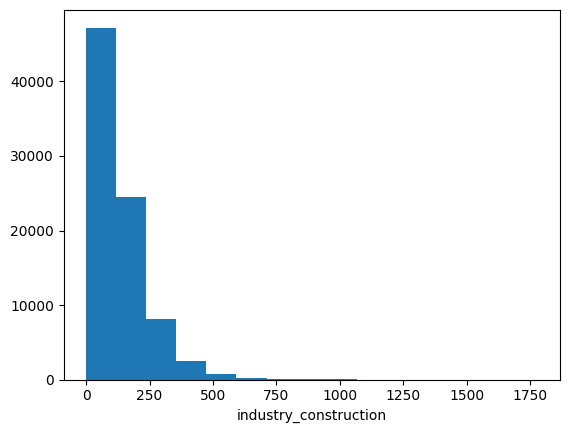

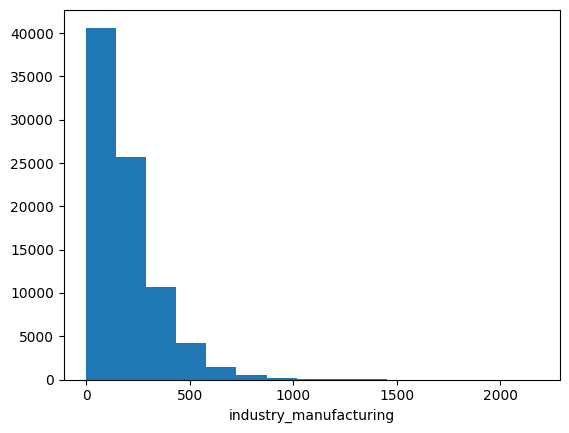

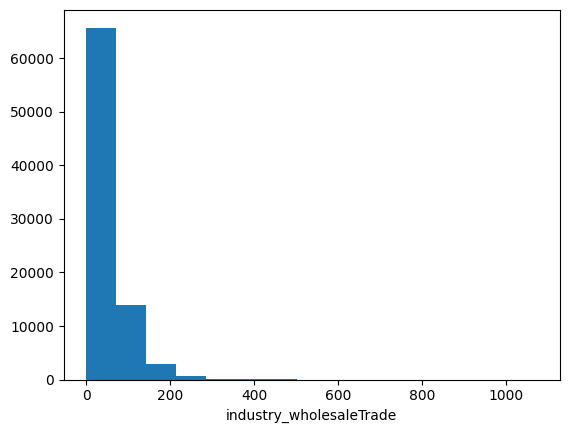

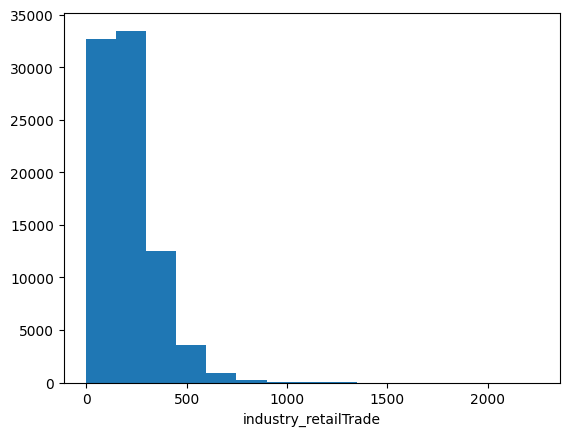

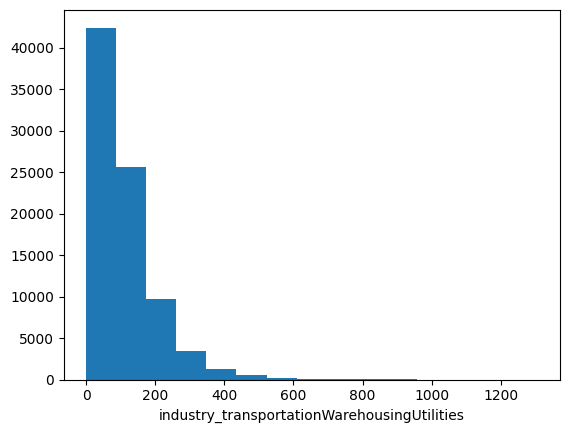

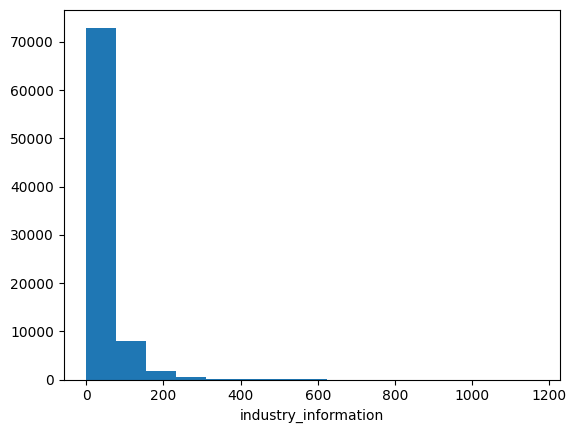

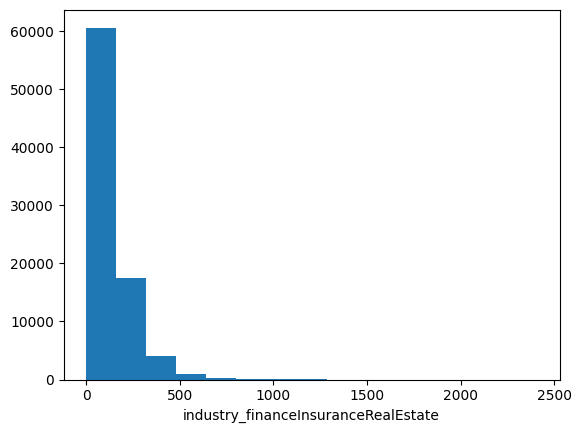

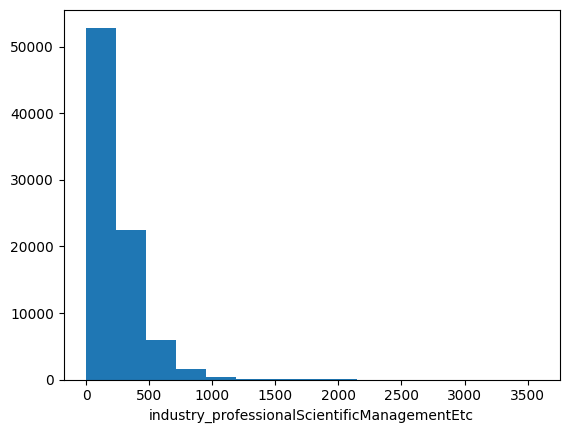

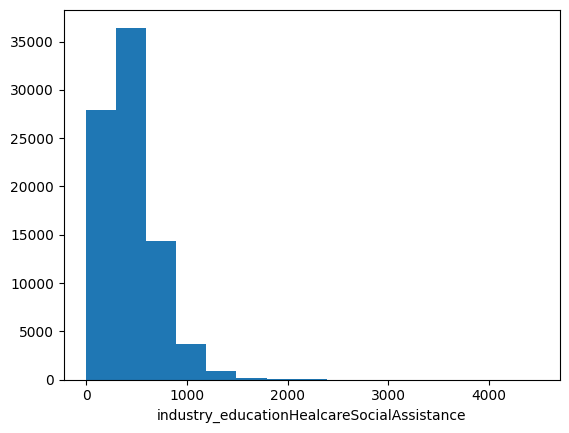

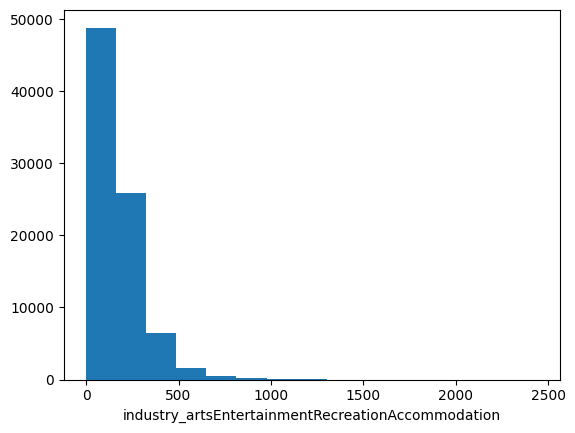

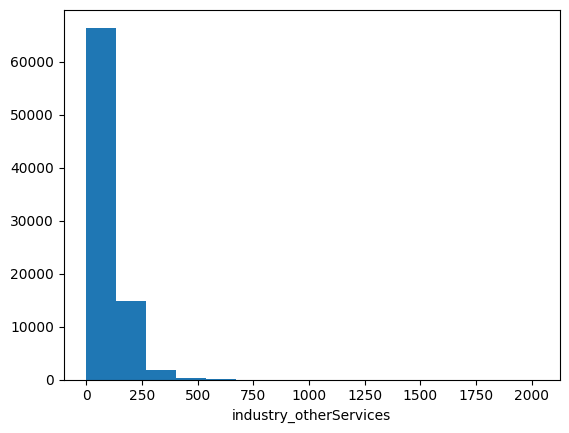

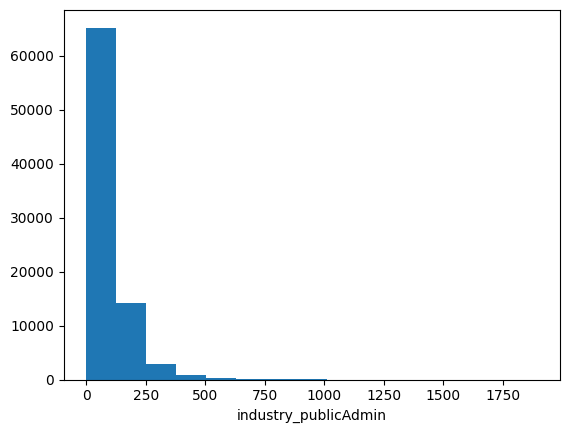

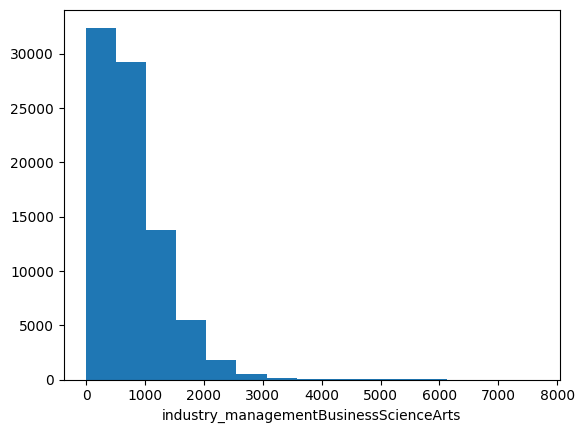

In [22]:
## check outliers

##check for outliers
df_census = df_census.replace(-666666666, np.nan)
census_numeric_names = df_census.columns.drop(['Name', 'state', 'county', 'tract'])

df_census[census_numeric_names] = df_census[census_numeric_names].apply(pd.to_numeric, errors='ignore')

### check numeric outliers
for n in df_census[census_numeric_names].columns:
    plt.hist(df_census[census_numeric_names][n], bins=15)
    plt.xlabel(n)
    plt.show()

In [23]:
### merge census geography info w flood and census flood data
# keep all tracts and floods, including tracts with no floods

#make unique state-tract id on both dfs
df_census['tract_county_state'] = df_census['tract'] + '-' + df_census['county']+ '-' + df_census['state']
df_flood_tract['tract_county_state'] = df_flood_tract['TRACTCE'] + '-' + df_flood_tract['COUNTYFP'] + '-' + df_flood_tract['STATEFP']
# keep all tracts and floods
df_cen_fl_48 = df_census.merge(df_flood_tract, how='outer', left_on='tract_county_state', right_on='tract_county_state', validate='one_to_many') 
print('census data shape: ', df_census.shape)
print('census tracts without floods: ', df_cen_fl_48.loc[df_cen_fl_48['event_id'].isna()].shape)
print('flood data shape: ', df_flood_tract.shape)
print('floods without census tract match: ', df_cen_fl_48.loc[df_cen_fl_48['tract'].isna()].shape)


print('merged data shape: ', df_cen_fl_48.shape)

df_cen_fl_48.head().T

census data shape:  (83571, 51)
census tracts without floods:  (54527, 88)
flood data shape:  (103468, 38)
floods without census tract match:  (3159, 88)
merged data shape:  (157995, 88)


,0,1,2,3,4
Name,Census Tract 1; Adams County; Illinois,Census Tract 1; Allegany County; Maryland,Census Tract 1; Allegany County; Maryland,Census Tract 1; Allegany County; Maryland,Census Tract 1; Allegany County; Maryland
med_houseinc_12mon,61595.0,56232.0,56232.0,56232.0,56232.0
household_public_assistance1,2377.0,1577.0,1577.0,1577.0,1577.0
gini,0.4819,0.3839,0.3839,0.3839,0.3839
total_population,16873.0,12003.0,12003.0,12003.0,12003.0
...,...,...,...,...,...
event_narrative,NaN,Flooding occurred along the banks of the C and...,A Trained Spotter reported flooding of Town Cr...,A trained spotter reported Route 144 (National...,Flash flooding was occurring over Dickerson Ho...
data_source,NaN,PDS,CSV,CSV,CSV
TRACTCE,NaN,000100,000100,000100,000100
STATEFP,NaN,24,24,24,24


In [24]:

# add column to count floods
# event id is flood event, so null event_id is for tracts with no floods
df_cen_fl_48['flood_count'] = df_cen_fl_48['event_id'].apply(lambda x: 0 if np.isnan(x) else 1) 
# add seasonal flood count metrics
df_cen_fl_48['flood_count_fall'] = df_cen_fl_48['month_name'].apply(lambda x: 1 if x in ['October', 'November', 'December'] else 0)
df_cen_fl_48['flood_count_winter'] = df_cen_fl_48['month_name'].apply(lambda x: 1 if x in ['January', 'February', 'March'] else 0)
df_cen_fl_48['flood_count_spring'] = df_cen_fl_48['month_name'].apply(lambda x: 1 if x in ['April', 'May', 'June'] else 0)



In [25]:
#check for missing data
print(len(df_cen_fl_48))
df_cen_fl_48.isna().sum().sort_values(ascending=False)


157995


event_narrative       59863
damage_crops          59619
damage_property       58006
episode_narrative     57789
begin_date_time       54527
                      ...  
tract_county_state        0
flood_count               0
flood_count_fall          0
flood_count_winter        0
flood_count_spring        0
Length: 92, dtype: int64

In [26]:
## narravtive column missing to be replaced with 'None' and No Info Available. 
## Text fields that will need to be converted somehow later anyway. 
df_cen_fl_48 = df_cen_fl_48.fillna({'episode_narrative': 'None', 'event_narrative': 'None', 
                                    'damage_property': 'No Info Available', 'damage_crops': 'No Info Available'
                                   })
# ##drop null values where household_public_assistance is missing
# df_final = df_cen_fl_48.dropna(subset='med_houseinc_12mon')
# print('final number of floods:', df_final['flood_count'].sum(), 'number of zip codes:', len(df_final))
# df_final.isna().sum()

Three categories of missing data. 
1. 54527 census tracts don't have flood data (out of 85k) - keep data as flood count 0
2. 3159 flood missing census tracts - in really remote areas, drop data
3. Several census metrics missing data (total population, med_houseinc_12mon, median_monthly_housing_costs, gini, median_age_female (male)) - keep for now.  

In [27]:
#check for missing data
print(len(df_cen_fl_48))
pd.set_option('display.max_rows', None)
display(df_cen_fl_48.isna().sum().sort_values(ascending=False))
pd.reset_option('display.max_rows')

157995


cz_fips                                              54527
event_id                                             54527
cz_type                                              54527
event_type                                           54527
month_name                                           54527
year                                                 54527
state_fips                                           54527
state_y                                              54527
episode_id                                           54527
wfo                                                  54527
end_time                                             54527
end_day                                              54527
end_yearmonth                                        54527
begin_time                                           54527
begin_day                                            54527
begin_yearmonth                                      54527
cz_name                                              545

In [28]:
#remove floods with missing census tract
df_final = df_cen_fl_48.dropna(subset=['tract', 'state_x', 'county'])
print(len(df_cen_fl_48))
pd.set_option('display.max_rows', None)
display(df_cen_fl_48.isna().sum().sort_values(ascending=False))
pd.reset_option('display.max_rows')

157995


cz_fips                                              54527
event_id                                             54527
cz_type                                              54527
event_type                                           54527
month_name                                           54527
year                                                 54527
state_fips                                           54527
state_y                                              54527
episode_id                                           54527
wfo                                                  54527
end_time                                             54527
end_day                                              54527
end_yearmonth                                        54527
begin_time                                           54527
begin_day                                            54527
begin_yearmonth                                      54527
cz_name                                              545

Some census data is just not available for certain zctas and variables. 
I was able to track down the specific reason these data were not available. 
More information available here: https://www.census.gov/programs-surveys/acs/technical-documentation/data-suppression.html

In [29]:
##check for duplicates
print('there are ', df_final.duplicated(subset=['tract_county_state', 'event_id', 'year']).sum(), 'duplicates')

there are  0 duplicates


In [30]:
# df_final.groupby('tract_county_state').median()
pd.set_option('display.max_rows', None)
display(df_final.dtypes)
pd.reset_option('display.max_rows')



Name                                                  object
med_houseinc_12mon                                   float64
household_public_assistance1                         float64
gini                                                 float64
total_population                                     float64
total_male                                           float64
total_female                                         float64
total_travel_time_to_work                            float64
median_monthly_housing_costs                         float64
total_monthlyHousingCosts                            float64
total_HousingCosts_lessThan100                       float64
total_HousingCosts_500To599                          float64
total_HousingCosts_1000To1499                        float64
total_HousingCosts_1500To1999                        float64
total_HousingCosts_2000To2499                        float64
total_HousingCosts_2500To2999                        float64
total_HousingCosts_3000O

In [31]:
### calculate number of events since certain year, and flood duration, compute dataset by tract
object_cols = df_final.loc[:, df_final.dtypes == 'object'].dtypes.index.tolist()
numeric_cols = df_final.loc[:, df_final.dtypes != 'object'].dtypes.index.tolist()
numeric_cols_to_drop = ['year', 'event_id', 'deaths_direct', 'deaths_indirect', 'injuries_direct', 'injuries_indirect', 'episode_id', 
                        'end_time', 'begin_time', 'end_yearmonth', 'end_day', 'begin_day', 'begin_yearmonth']

names_to_sum = ['flood_count', 'flood_count_fall', 'flood_count_winter', 'flood_count_spring']

names_to_keep = [x for x in numeric_cols if x not in numeric_cols_to_drop + names_to_sum]

d1 = dict.fromkeys(names_to_keep, 'median')
# d2 = dict.fromkeys(['state_fips'], 'first') ## keep first state fips as some zip codes have multiple states
d3 = dict.fromkeys(names_to_sum, 'sum')

df_tract = df_final[names_to_keep + names_to_sum + ['tract_county_state']].groupby('tract_county_state').agg({**d1, **d3})
df_tract.rename(columns={'flood_count': 'nflood_total'}, inplace=True)

## calculate decadal floods
df_tract['nflood_2000s'] = df_final.loc[df_final['year'].between(2000, 2010, inclusive='left'), ['tract_county_state', 'flood_count']].groupby('tract_county_state').sum()
df_tract['nflood_2010s'] = df_final.loc[df_final['year'].between(2010, 2020, inclusive='left'), ['tract_county_state', 'flood_count']].groupby('tract_county_state').sum()
#fill na with zero floods
df_tract[['nflood_2000s', 'nflood_2010s']] = df_tract[['nflood_2000s', 'nflood_2010s']].fillna(0, axis=1)

df_final.loc[:, 'flood_duration'] = (pd.to_datetime(df_final['end_date_time']) - pd.to_datetime(df_final['begin_date_time'])).apply(pd.Timedelta.total_seconds) 
df_final['flood_duration'] = df_final['flood_duration'].fillna(0) # fill rows with no flood info with zero flood duration

df_tract.loc[:,'flood_dur_hours_median'] = df_final[['tract_county_state', 'flood_duration']].groupby('tract_county_state').median() / 3660.0
df_tract.loc[:,'flood_dur_hours_min'] = df_final[['tract_county_state', 'flood_duration']].groupby('tract_county_state').min() / 3660.0
df_tract.loc[:,'flood_dur_hours_max'] = df_final[['tract_county_state', 'flood_duration']].groupby('tract_county_state').max() / 3660.0

df_tract.head()


/var/folders/k2/8b5d5rd53t38_t4lfc676zsr0000gp/T/ipykernel_14206/3034026634.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_final.loc[:, 'flood_duration'] = (pd.to_datetime(df_final['end_date_time']) - pd.to_datetime(df_final['begin_date_time'])).apply(pd.Timedelta.total_seconds)
/var/folders/k2/8b5d5rd53t38_t4lfc676zsr0000gp/T/ipykernel_14206/3034026634.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_final.loc[:, 'flood_duration'] = (pd.to_datetime(df_final['end_date_time']) - pd.to_datetime(df_final['begin_date_time'])).apply(pd.Timedelta.total_seconds)
/var/folders/k2/8b5d5rd53t38_t4lfc676zsr0000gp/T/ipykernel_14206/3034026634.py:24: SettingWithCopyWarning: 
A value is trying to be set on a c

,med_houseinc_12mon,household_public_assistance1,gini,total_population,total_male,total_female,total_travel_time_to_work,median_monthly_housing_costs,total_monthlyHousingCosts,total_HousingCosts_lessThan100,...,industry_managementBusinessScienceArts,nflood_total,flood_count_fall,flood_count_winter,flood_count_spring,nflood_2000s,nflood_2010s,flood_dur_hours_median,flood_dur_hours_min,flood_dur_hours_max
tract_county_state,,,,,,,,,,,,,,,,,,,,,
000100-001-17,61595.0,2377.0,0.4819,16873.0,1900.0,2609.0,2020.0,760.0,2377.0,0.0,...,665.0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.000000
000100-001-24,56232.0,1577.0,0.3839,12003.0,1903.0,1571.0,1214.0,654.0,1577.0,0.0,...,256.0,11,0,1,4,3.0,7.0,3.459016,0.983607,23.606557
000100-001-26,62348.0,858.0,0.4091,21071.0,807.0,891.0,354.0,672.0,858.0,8.0,...,205.0,1,0,0,0,1.0,0.0,10.065574,10.065574,10.065574
000100-001-30,59375.0,609.0,0.4378,19131.0,715.0,657.0,514.0,635.0,609.0,6.0,...,294.0,1,0,0,0,0.0,1.0,0.491803,0.491803,0.491803
000100-001-34,44091.0,884.0,0.4213,8951.0,1273.0,1072.0,946.0,1273.0,884.0,57.0,...,215.0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.000000


# Download NHD Data 
Streamline length as a measure for proximity to flooding source

In [32]:
mr = NHD("flowline_mr")##medium resolution nhd data
tracts_ex = tracts.explode(index_parts=False)## explode multipolygons
print(tracts.shape)
print(tracts_ex.shape)
tracts_ex = tracts_ex.reset_index(drop=True)#.drop(['index'], axis=1) ## remove multi index
tracts_ex['tract_county_state'] = tracts_ex['TRACTCE'] + '-' + tracts_ex['COUNTYFP']+ '-' + tracts_ex['STATEFP']


for tract_n in df_tract.index: ##loop through tracts

### this bit of code from https://github.com/hyriver/pynhd
    data_this_tract = tracts_ex.loc[tracts_ex['tract_county_state'] == tract_n, :]
    
    channel_sum = 0 ##running total of channel length for zip code, takes into account multipolygons
    for n in data_this_tract.index:
        
        try: 
            nhd_tract = mr.bygeom(data_this_tract.loc[n, :].geometry)
            channel_sum = channel_sum + nhd_tract['LENGTHKM'].sum()
        except: ##some polys are tiny and have no streamlines
            print('No matched records', tract_n)
            channel_sum = channel_sum
        
        # print(channel_sum, tract_n)
    df_tract.loc[tract_n, 'channel_length_km'] = channel_sum ## add total channel length to output file

(85528, 13)
(85905, 13)
No matched records 000100-001-34
No matched records 000100-007-36
No matched records 000100-009-35
No matched records 000100-011-42
No matched records 000100-017-39
No matched records 000100-019-04
No matched records 000100-019-06
No matched records 000100-019-22
No matched records 000100-021-37
No matched records 000100-025-35
No matched records 000100-025-55
No matched records 000100-027-04
No matched records 000100-029-35
No matched records 000100-035-35
No matched records 000100-041-35
No matched records 000100-047-36
No matched records 000100-055-22
No matched records 000100-059-21
No matched records 000100-061-26
No matched records 000100-061-36
No matched records 000100-061-36
No matched records 000100-065-26
No matched records 000100-067-37
No matched records 000100-071-36
No matched records 000100-071-42
No matched records 000100-073-06
No matched records 000100-073-22
No matched records 000100-075-26
No matched records 000100-077-53
No matched records 

In [33]:
#check missing values
df_tract.isna().sum()

med_houseinc_12mon                                      0
household_public_assistance1                            0
gini                                                    0
total_population                                     6027
total_male                                              0
total_female                                            0
total_travel_time_to_work                               0
median_monthly_housing_costs                            0
total_monthlyHousingCosts                               0
total_HousingCosts_lessThan100                          0
total_HousingCosts_500To599                             0
total_HousingCosts_1000To1499                           0
total_HousingCosts_1500To1999                           0
total_HousingCosts_2000To2499                           0
total_HousingCosts_2500To2999                           0
total_HousingCosts_3000OrMore                           0
median_age_male                                         0
median_age_fem

In [34]:
### save final data

df_final.to_csv('data/01_datawrangling_byflood_out.csv')
df_tract.to_csv('data/01_datawrangling_bytract_out.csv')


<Axes: >

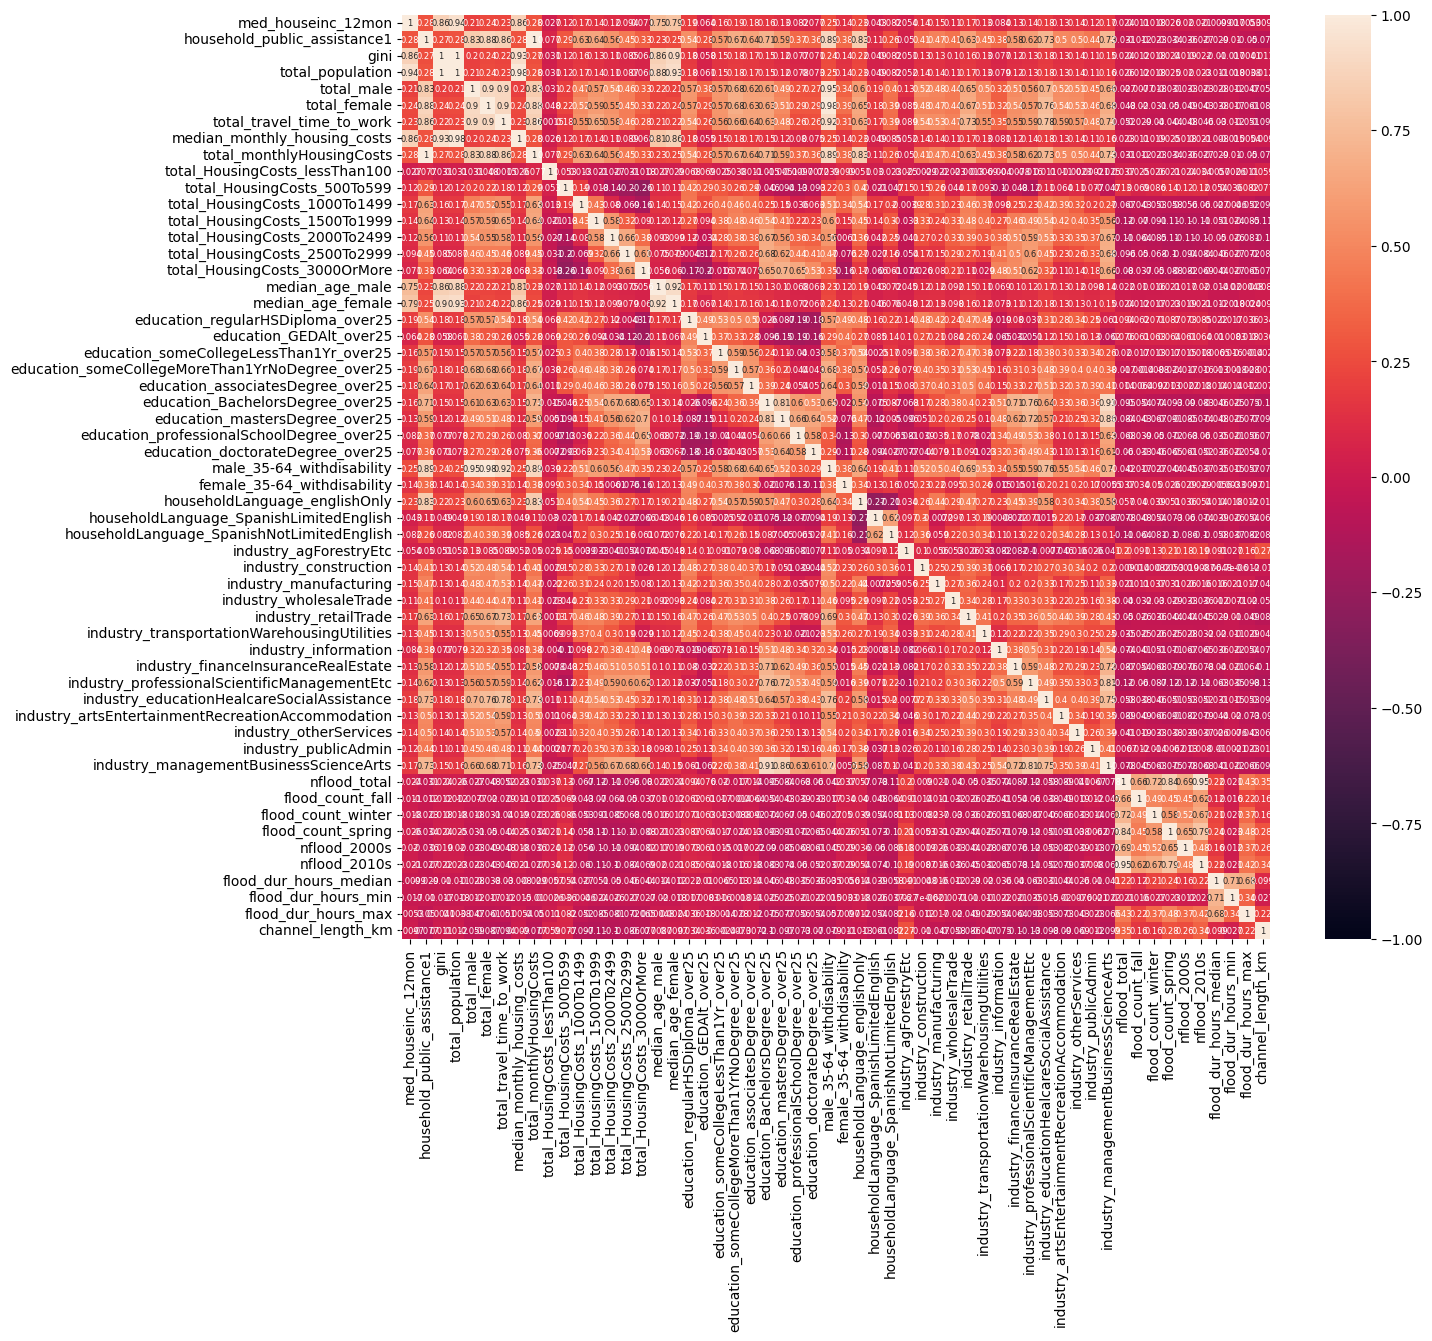

In [35]:
f, ax = plt.subplots(1, 1, figsize=(14, 12))
sns.heatmap(df_tract.corr(), vmin=-1, vmax=1, ax=ax, annot=True, annot_kws={"fontsize":6})


In [36]:
df_tract.corr()[['nflood_total', 'flood_count_winter', 'flood_count_spring']].sort_values('nflood_total')

,nflood_total,flood_count_winter,flood_count_spring
industry_professionalScientificManagementEtc,-0.119631,-0.087442,-0.121174
total_HousingCosts_1500To1999,-0.117643,-0.091280,-0.112257
total_HousingCosts_2000To2499,-0.114257,-0.084679,-0.112607
householdLanguage_SpanishNotLimitedEnglish,-0.108921,-0.080909,-0.104547
total_HousingCosts_2500To2999,-0.096300,-0.067558,-0.100073
education_BachelorsDegree_over25,-0.095354,-0.073881,-0.092784
industry_artsEntertainmentRecreationAccommodation,-0.088841,-0.065726,-0.090843
industry_financeInsuranceRealEstate,-0.086638,-0.068453,-0.079141
education_mastersDegree_over25,-0.083882,-0.066612,-0.090545
total_HousingCosts_3000OrMore,-0.080343,-0.049699,-0.088308


Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/miniconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/miniconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/miniconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/opt/miniconda3/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/opt/miniconda3/lib/python3.12/asyncio/base_events.py", line 641, in run_forever
    self._run_once()
  File "/opt/miniconda3/lib/python3.12/asyncio/base_events.py", line 1972, in _run_once
    handle = self._ready.popleft()
             ^^^^^^^^^^^^^^^^^^^^^
IndexError: pop from an empty deque
